In [1]:
# !pip install geojson
# !pip install folium
# !pip install geopandas
# !pip install pyogrio

In [53]:
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import json
import folium
import geopandas as gpd
import pyogrio
from shapely.ops import split
from shapely.geometry import MultiLineString, LineString, Point, Polygon, MultiPolygon
import pandas as pd
import numpy as np
from folium.plugins import MarkerCluster

import requests
import json


# France GeoJSON

### Loading and understanding data

In [3]:
file_geojson = '../data/communes-version-simplifiee.geojson'

# Load GeoJSON data
with open(file_geojson, 'r') as f:
    geojson_data = json.load(f)

In [4]:
# Inspect the type of the GeoJSON object
print(geojson_data['type'])  # Likely 'FeatureCollection'

# List all features
features = geojson_data['features']
print(f"Number of features: {len(features)}")

# Example: Access the first feature's geometry
print(features[0]['geometry'])

FeatureCollection
Number of features: 35228
{'type': 'Polygon', 'coordinates': [[[5.6981632192136304, 45.861664838781984], [5.704706905938662, 45.86124707033062], [5.728134452402571, 45.84811439260961], [5.748522296789798, 45.83524885057134], [5.7640692199110655, 45.83449992725118], [5.763159151452136, 45.825079272154916], [5.741495539902308, 45.817317892592186], [5.727236540825587, 45.81997893113966], [5.710445940180589, 45.81402210705237], [5.701642919894025, 45.81160217267361], [5.676993923274336, 45.82938070631847], [5.694763010068678, 45.83457134219822], [5.6981632192136304, 45.861664838781984]]]}


In [5]:
# Chaque ville a une géométrie (polygone défini par les coins) + des propriétés (code et nom)
print(features[0].keys())
print(features[0]['geometry'])
print(features[0]['properties'])

dict_keys(['type', 'geometry', 'properties'])
{'type': 'Polygon', 'coordinates': [[[5.6981632192136304, 45.861664838781984], [5.704706905938662, 45.86124707033062], [5.728134452402571, 45.84811439260961], [5.748522296789798, 45.83524885057134], [5.7640692199110655, 45.83449992725118], [5.763159151452136, 45.825079272154916], [5.741495539902308, 45.817317892592186], [5.727236540825587, 45.81997893113966], [5.710445940180589, 45.81402210705237], [5.701642919894025, 45.81160217267361], [5.676993923274336, 45.82938070631847], [5.694763010068678, 45.83457134219822], [5.6981632192136304, 45.861664838781984]]]}
{'code': '01073', 'nom': 'Ceyzérieu'}


### Extracting data for La Baule

In [6]:
# Find the city with the specific name
def get_city_by_name(city_name):
    city_with_property = next(
        (feature for feature in geojson_data["features"] 
        if feature["properties"].get('nom') == city_name), 
        None
    )
    # Output the result
    if city_with_property:
        print(f"City {city_name} found:")
    else:
        print(f"No city with the name {city_name} found.")   
    return city_with_property

# Find the city with a specific INSEE code
def get_city_by_code(city_code):
    city_with_property = next(
        (feature for feature in geojson_data["features"] 
        if feature["properties"].get('code') == city_code), 
        None
    )
    # Output the result
    if city_with_property:
        print(f"City with code {city_code} found.")
    else:
        print(f"No city with the name {city_code} found.")
    return city_with_property

def plot_city(city):
    long_o = city["geometry"]['coordinates'][0][0][0]
    lat_o = city["geometry"]['coordinates'][0][0][1]
    m = folium.Map([lat_o, long_o], zoom_start=12)
    folium.GeoJson(city).add_to(m)
    return m 

Note :
* Les codes des communes sont ceux de l'INSEE
* On peut les retrouver manuellement ici : https://www.insee.fr/fr/recherche/recherche-geographique?debut=0

In [7]:
# city_name = "Cachan"
# city = get_city_by_name(city_name)
city_code = '44055'
city = get_city_by_code(city_code)
plot_city(city)

City with code 44055 found.


### DB IGN : Routes, Points d'intérêts, Habitations

### Loading and understanding

In [8]:
file_ign_44 = '../Data/BDCARTO/44_Loire_Atlantique/1_DONNEES_LIVRAISON_2024-12-00080/data.gpkg'
df_layers = gpd.list_layers(file_ign_44)

c:\Users\eliot\anaconda3\Lib\site-packages\pyogrio\core.py:130: RuntimeWarning: Field format 'character varying' not supported
  return ogr_list_layers(get_vsi_path_or_buffer(path_or_buffer))
c:\Users\eliot\anaconda3\Lib\site-packages\pyogrio\core.py:130: RuntimeWarning: Field format 'character varying(256)' not supported
  return ogr_list_layers(get_vsi_path_or_buffer(path_or_buffer))
c:\Users\eliot\anaconda3\Lib\site-packages\pyogrio\core.py:130: RuntimeWarning: Field format 'character varying(30)' not supported
  return ogr_list_layers(get_vsi_path_or_buffer(path_or_buffer))
c:\Users\eliot\anaconda3\Lib\site-packages\pyogrio\core.py:130: RuntimeWarning: Field format 'timestamp with time zone' not supported
  return ogr_list_layers(get_vsi_path_or_buffer(path_or_buffer))


In [9]:
# Toutes les données dispo
df_layers

name    geometry_type
0        construction_ponctuelle            Point
1          construction_lineaire       LineString
2                      cimetiere     MultiPolygon
3                      reservoir            Point
4        construction_surfacique     MultiPolygon
5               troncon_de_route       LineString
6      route_numerotee_ou_nommee  MultiLineString
7                     rond_point            Point
8         troncon_de_voie_ferree       LineString
9        equipement_de_transport     MultiPolygon
10             piste_d_aerodrome     MultiPolygon
11                     aerodrome     MultiPolygon
12                   cours_d_eau  MultiLineString
13        troncon_hydrographique       LineString
14        surface_hydrographique     MultiPolygon
15                    plan_d_eau     MultiPolygon
16          noeud_hydrographique            Point
17              limite_terre_mer       LineString
18         detail_hydrographique            Point
19  bassin_versant_topographique     MultiPolygon
20           detail_orographique            Point
21             zone_d_habitation            Point
22           lieu_dit_non_habite            Point
23              ligne_electrique       LineString
24  zone_d_activite_ou_d_interet     MultiPolygon
25                       commune     MultiPolygon
26  commune_associee_ou_deleguee     MultiPolygon
27                arrondissement     MultiPolygon
28                   departement     MultiPolygon
29     collectivite_territoriale     MultiPolygon
30                          epci     MultiPolygon
31                        region     MultiPolygon
32               parc_ou_reserve     MultiPolygon
33             occupation_du_sol     MultiPolygon
34              info_metadonnees             None
35               metadonnees_lot             None
36             metadonnees_theme             None
37                  layer_styles             None

In [10]:
# Data qui peuvent nous intéresser
liste_layer_interet = [ 'commune', 'troncon_de_route', 'route_numerotee_ou_nommee', 'zone_d_habitation', 'zone_d_activite_ou_d_interet', 'ligne_electrique']

### Contour de la Baule

In [11]:
# Charger un fichier GeoPackage
gdf_commune = gpd.read_file(file_ign_44, layer="commune")

In [12]:
# Code Insee n'est pas un identifiant unique
# gdf_code_insee = gdf[gdf['code_insee'] == '44055']
# gdf_la_baule = gdf_code_insee[gdf_code_insee['nom_officiel'].str.contains('Baule', na=False)]

# Le code postal a l'air d'être un identifiant unique
gdf_la_baule = gdf_commune[gdf_commune['code_postal'] == '44500']
gdf_la_baule

cleabs code_insee code_insee_de_l_arrondissement  \
266  COMMUNE_0000000009745827      44055                              3   

    code_insee_de_la_collectivite_terr code_insee_du_departement  \
266                                44D                        44   

    code_insee_de_la_region  population  surface_en_ha code_postal  \
266                      52       16468           2219       44500   

           nom_officiel  chef_lieu_d_arrondissement  \
266  La Baule-Escoublac                       False   

     chef_lieu_de_collectivite_terr  chef_lieu_de_departement  \
266                           False                     False   

     chef_lieu_de_region  capitale_d_etat date_du_recensement  \
266                False            False          2021-01-01   

    organisme_recenseur       lien_vers_chef_lieu code_siren  \
266               INSEE  PAIHABIT0000000028858387  214400558   

                                              geometry  
266  MULTIPOLYGON (((300057.1 6702628.1, 300040.5 6...

In [13]:
ign_geometry_la_baule = gdf_la_baule.iloc[0].geometry  # Extract the polygon geometry

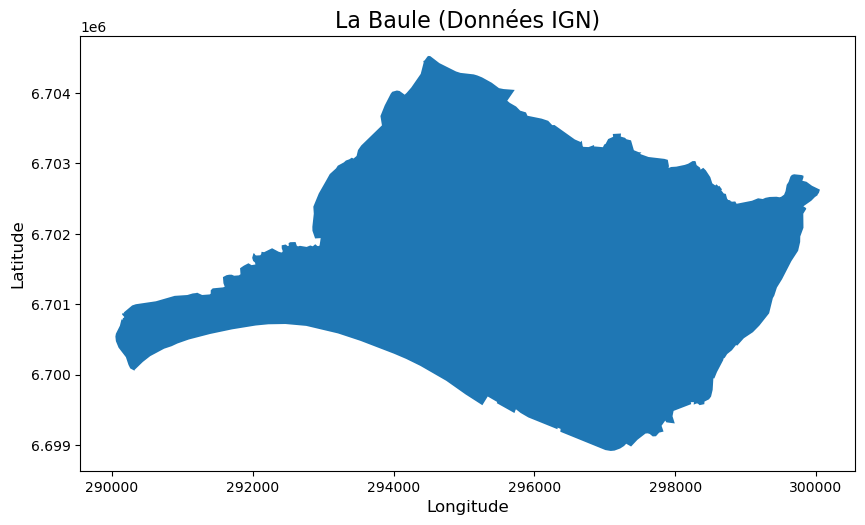

In [14]:
# Plot the city
fig, ax = plt.subplots(figsize=(10, 10))
gdf_la_baule.plot(ax=ax, linewidth=1)

# Customize the plot
ax.set_title("La Baule (Données IGN)", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Show the plot
plt.show()

## Points d'intérêts

### POIs in La Baule

In [15]:
# Charger un fichier GeoPackage
gdf_poi_44 = gpd.read_file(file_ign_44, layer="zone_d_activite_ou_d_interet")

# Filter only POIs that intersect with the city polygon
gdf_pois_in_city = gdf_poi_44[gdf_poi_44.geometry.intersects(ign_geometry_la_baule)]

# gdf_poi_44.shape
gdf_pois_in_city

cleabs                 categorie             nature  \
467  SURFACTI0000000028744589  Industriel et commercial  Zone industrielle   

    nature_detaillee                    toponyme statut_du_toponyme  fictif  \
467             None  Zone Industrielle de Brais             Validé   False   

                                              geometry  
467  MULTIPOLYGON (((299993.5 6702453.7, 299937.7 6...

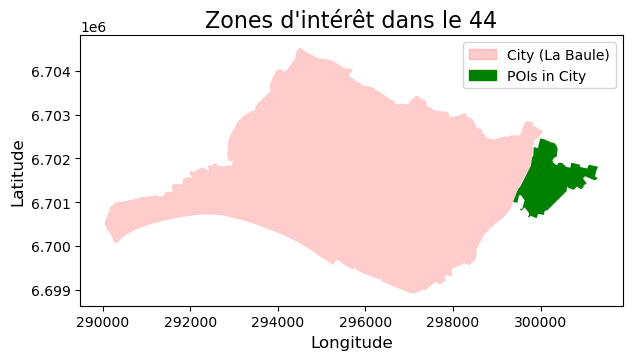

In [16]:
# Plot the POIs
fig, ax = plt.subplots(figsize=(7, 7))
gdf_la_baule.plot(ax=ax, color = 'red', linewidth=1, alpha = 0.2)
gdf_pois_in_city.plot(ax=ax, color = 'green', linewidth=1, alpha = 1)

# Create a manual legend
legend_city = mpatches.Patch(color="red", alpha=0.2, label="City (La Baule)")
legend_pois_in_city = mpatches.Patch(color="green", label="POIs in City")
ax.legend(handles=[legend_city, legend_pois_in_city], loc="upper right")

# Customize the plot
ax.set_title("Zones d'intérêt dans le 44", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Show the plot
plt.show()

### Tronçons de route

In [17]:
# Charger un fichier GeoPackage
gdf_troncons_44 = gpd.read_file(file_ign_44, layer="troncon_de_route")

# Filter only POIs that intersect with the city polygon
gdf_troncons_in_city = gdf_troncons_44[gdf_troncons_44.geometry.intersects(ign_geometry_la_baule)]
gdf_troncons_in_city.shape

(1638, 26)

In [18]:
# gdf_troncons_in_city.head()
print(gdf_troncons_in_city.columns)
liste_interet = ['nombre_de_voies', 'largeur_de_chaussee', 'vitesse_moyenne_vl', 'liens_vers_route_nommee']

Index(['cleabs', 'cleabs_ge', 'etat_de_l_objet', 'date_de_mise_en_service',
       'nature', 'position_par_rapport_au_sol', 'importance',
       'nombre_de_voies', 'largeur_de_chaussee', 'itineraire_vert',
       'sens_de_circulation', 'acces_vehicule_leger', 'periode_de_fermeture',
       'restriction_de_hauteur', 'restriction_de_poids_total', 'fictif',
       'vitesse_moyenne_vl', 'liens_vers_route_nommee', 'cpx_numero',
       'cpx_numero_route_europeenne', 'cpx_classement_administratif',
       'cpx_gestionnaire', 'cpx_toponyme_route_nommee',
       'cpx_toponyme_iti_cyclable', 'cpx_toponyme_voie_verte', 'geometry'],
      dtype='object')


In [19]:
# Mesure de l'importance d'une route
# gdf_troncons_in_city.nature.value_counts()
# gdf_troncons_in_city.importance.value_counts()
# gdf_troncons_in_city.largeur_de_chaussee.value_counts()
# gdf_troncons_in_city.vitesse_moyenne_vl.value_counts()
# gdf_troncons_in_city.liens_vers_route_nommee.value_counts()

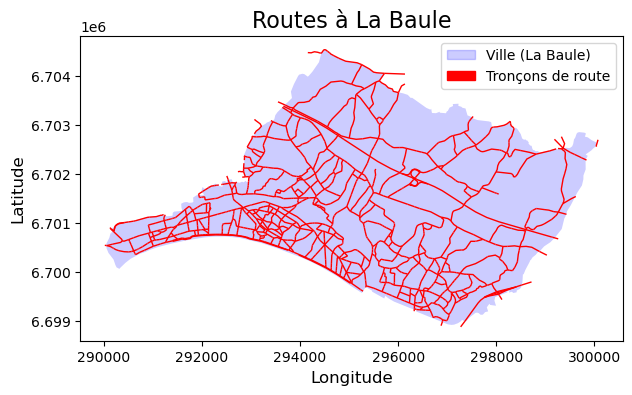

In [20]:
# Plot the routes
fig, ax = plt.subplots(figsize=(7, 7))
gdf_la_baule.plot(ax=ax, color = 'blue', linewidth=1, alpha = 0.2)
gdf_troncons_in_city.plot(ax=ax, color = 'red', linewidth=1, alpha = 1)

# Create a manual legend
legend_city = mpatches.Patch(color="blue", alpha=0.2, label="Ville (La Baule)")
legend_in_city = mpatches.Patch(color="red", label="Tronçons de route")
ax.legend(handles=[legend_city, legend_in_city], loc="upper right")

# Customize the plot
ax.set_title("Routes à La Baule", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Show the plot
plt.show()

#### NOTES : 
* les coordonnées des routes ne correspondent pas à lattitude / longitude. Il faudra preprocess pour afficher sur la map
* sinon on peut plot avec les coordonnées des villes sous le même format (dipso dans le df)

### Routes

In [21]:
# Charger un fichier GeoPackage
gdf_routes_nommees = gpd.read_file(file_ign_44, layer="route_numerotee_ou_nommee")

# Afficher les 5 premières lignes
# print(gdf.head())
print(len(gdf_routes_nommees))
print(gdf_routes_nommees.columns)
print(gdf_routes_nommees.loc[0]['geometry'])

573
Index(['cleabs', 'cleabs_ge', 'type_de_route', 'numero', 'gestionnaire',
       'toponyme', 'statut_du_toponyme', 'geometry'],
      dtype='object')
MULTILINESTRING ((385051.4 6746567.8, 385301.8 6746548.1, 385580.6 6746525.6, 385620.2 6746522.1, 385642.5 6746520.7, 385683.8 6746517.8, 385904.6 6746502, 386006.8 6746494.3, 386069 6746483.2, 386257 6746398.7, 386503.1 6746284.4, 386691.3 6746192.5, 386708.8 6746188.4, 386729.7 6746179.3, 386811.2 6746142.5, 386831.5 6746133.1, 386852.6 6746123.6, 386867.1 6746117.3, 386885.9 6746115.6, 386894.5 6746100.2, 386887 6746077.7, 386939.3 6745997, 386962.2 6745937, 387016.6 6745822.8, 387040.3 6745789.5, 387045.2 6745778.7, 387046.8 6745763.4, 387045.6 6745741.9, 387042 6745697.7, 387041.1 6745682.2, 387032.7 6745556.3, 387027.5 6745492.3, 387022.5 6745396.3, 386989.4 6744890.1, 386988.4 6744873.6, 386958.2 6744413.5, 386939.7 6744126.5, 386937.8 6744097.3, 386920.1 6743821.1, 386897.1 6743473.1, 386896.2 6743466.7, 386895.4 6743460.4, 386

In [22]:
# Clip each MultiLineString to keep only the parts inside the city
def clip_multilinestring(mls, polygon):
    """Clip a MultiLineString to keep only the segments inside the polygon."""
    if mls.is_empty:
        return MultiLineString()  # Return empty MultiLineString if no intersection

    clipped_segments = [line.intersection(polygon) for line in mls.geoms if line.intersects(polygon)]
    # clipped_segments = [line for line in mls.geoms if line.intersects(polygon)]
    clipped_segments = [seg for seg in clipped_segments if isinstance(seg, LineString)]  # Keep only LineStrings

    return MultiLineString(clipped_segments) if clipped_segments else MultiLineString()  # Return MultiLineString

In [23]:
# Filter only POIs that intersect with the city polygon
gdf_routes_nommees_in_city = gdf_routes_nommees[gdf_routes_nommees.geometry.intersects(ign_geometry_la_baule)]
print(gdf_routes_nommees_in_city['type_de_route'].value_counts())

# Apply the clipping function to each route
gdf_routes_nommees_in_city["geometry"] = gdf_routes_nommees_in_city["geometry"].apply(lambda geom: clip_multilinestring(geom, ign_geometry_la_baule))

# Step 3: Remove empty geometries (if some routes were completely outside)
gdf_routes_nommees_in_city = gdf_routes_nommees_in_city[~gdf_routes_nommees_in_city.geometry.is_empty]

gdf_routes_nommees_in_city['type_de_route'].value_counts()

type_de_route
Départementale         6
Itinéraire cyclable    2
Route nommée           1
Name: count, dtype: int64


c:\Users\eliot\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


type_de_route
Départementale         5
Itinéraire cyclable    2
Route nommée           1
Name: count, dtype: int64

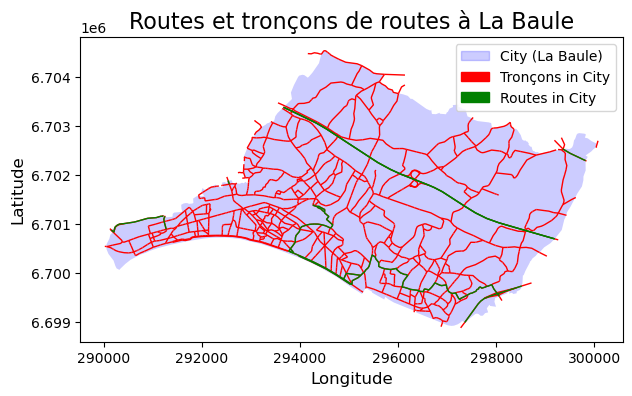

In [24]:
# Plot the POIs
fig, ax = plt.subplots(figsize=(7, 7))
gdf_la_baule.plot(ax=ax, color = 'blue', linewidth=1, alpha = 0.2)
gdf_troncons_in_city.plot(ax=ax, color = 'red', linewidth=1, alpha = 1)
gdf_routes_nommees_in_city.plot(ax=ax, color = 'green', linewidth=1, alpha = 1)

# Create a manual legend
legend_city = mpatches.Patch(color="blue", alpha=0.2, label="City (La Baule)")
legend_troncons_in_city = mpatches.Patch(color="red", label="Tronçons in City")
legend_routes_in_city = mpatches.Patch(color="green", label="Routes in City")
ax.legend(handles=[legend_city, legend_troncons_in_city, legend_routes_in_city], loc="upper right")

# Customize the plot
ax.set_title("Routes et tronçons de routes à La Baule", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Show the plot
plt.show()

### Zone d'habitations

In [25]:
# Charger un fichier GeoPackage
gdf_zone_habitation = gpd.read_file(file_ign_44, layer="zone_d_habitation")

# Afficher les 5 premières lignes
# print(gdf.head())
print(len(gdf_zone_habitation))
print(gdf_zone_habitation.columns)
print(gdf_zone_habitation.loc[0]['geometry'])
# print(len(gdf_zone_habitation)

5664
Index(['cleabs', 'nature', 'toponyme', 'statut_du_toponyme', 'geometry'], dtype='object')
POINT (384883 6752357.5)


In [26]:
# Filter only POIs that intersect with the city polygon
gdf_zone_habitation_in_city = gdf_zone_habitation[gdf_zone_habitation.geometry.intersects(ign_geometry_la_baule)]
gdf_zone_habitation_in_city.nature.value_counts()
gdf_quartier_in_city = gdf_zone_habitation_in_city[gdf_zone_habitation_in_city['nature'] == 'Quartier']

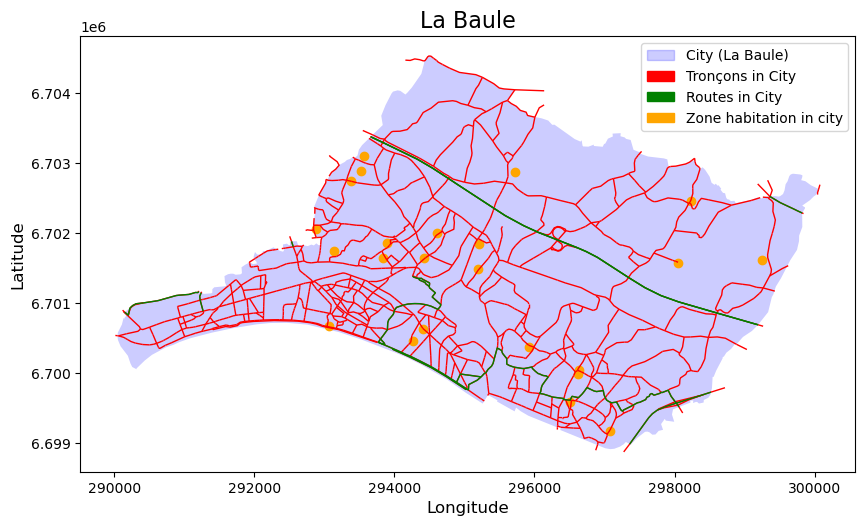

In [73]:
# Plot the POIs
fig, ax = plt.subplots(figsize=(10, 10))
gdf_la_baule.plot(ax=ax, color = 'blue', linewidth=1, alpha = 0.2)
gdf_troncons_in_city.plot(ax=ax, color = 'red', linewidth=1, alpha = 1)
gdf_routes_nommees_in_city.plot(ax=ax, color = 'green', linewidth=1, alpha = 1)
gdf_zone_habitation_in_city.plot(ax=ax, color = 'orange', linewidth=1, alpha = 1)
# gdf_pois_in_city.plot(ax=ax, color = 'pink', linewidth=1, alpha = 1)

# Create a manual legend
legend_city = mpatches.Patch(color="blue", alpha=0.2, label="City (La Baule)")
legend_troncons_in_city = mpatches.Patch(color="red", label="Tronçons in City")
legend_routes_in_city = mpatches.Patch(color="green", label="Routes in City")
legend_zone_habitation_in_city = mpatches.Patch(color="orange", label="Zone habitation in city")
# legend_pois_in_city = mpatches.Patch(color="pink", label="POI in city")
# ax.legend(handles=[legend_city, legend_troncons_in_city, legend_routes_in_city, legend_zone_habitation_in_city, legend_pois_in_city], loc="upper right")
ax.legend(handles=[legend_city, legend_troncons_in_city, legend_routes_in_city, legend_zone_habitation_in_city], loc="upper right")

# Customize the plot
ax.set_title("La Baule", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Show the plot
plt.show()

# Véhicules éléctriques

In [28]:
file_bornes = '../Data/consolidation-etalab-schema-irve-statique-v-2.3.1-20250123.csv'
df_bornes = pd.read_csv(file_bornes)
print(f"Raws: {len(df_bornes)}")
print(f"Columns: {len(df_bornes.columns)}")

Raws: 122211
Columns: 51


C:\Users\eliot\AppData\Local\Temp\ipykernel_10420\3076984900.py:2: DtypeWarning: Columns (12,18,19,20,21,22,24,29,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bornes = pd.read_csv(file_bornes)


In [29]:
# Convert latitude & longitude to a geometry column
df_bornes['geometry'] = df_bornes.apply(lambda row: Point(row['consolidated_longitude'], row['consolidated_latitude']), axis=1)

# Convert DataFrame to GeoDataFrame
gdf_bornes_gps = gpd.GeoDataFrame(df_bornes, geometry='geometry')

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326), which is standard for lat/lon
gdf_bornes_gps.set_crs(epsg=4326, inplace=True)

nom_amenageur  siren_amenageur  \
0            SOLVEO ENERGIES      508886132.0   
1            SOLVEO ENERGIES      508886132.0   
2            SOLVEO ENERGIES      508886132.0   
3            SOLVEO ENERGIES      508886132.0   
4            SOLVEO ENERGIES      508886132.0   
...                      ...              ...   
122206  CHELONIENS DIFFUSION      421526641.0   
122207        OPTEOR IMMOTIC      552008914.0   
122208           D2 FINANCES      801177528.0   
122209             WeeCharge      902305556.0   
122210    SAFEXIS EUROPE SAS      437854508.0   

                         contact_amenageur        nom_operateur  \
0               bornes@solveo-energies.com      SOLVEO ENERGIES   
1               bornes@solveo-energies.com      SOLVEO ENERGIES   
2               bornes@solveo-energies.com      SOLVEO ENERGIES   
3               bornes@solveo-energies.com      SOLVEO ENERGIES   
4               bornes@solveo-energies.com      SOLVEO ENERGIES   
...                                    ...                  ...   
122206             pierremoisson@orange.fr  LAST MILE SOLUTIONS   
122207  seikou.diakho@vinci-facilities.com            FRESHMILE   
122208        laurent.specht@volta-sas.com            FRESHMILE   
122209                  hello@weecharge.fr            WeeCharge   
122210           philippe.mang@safexis.com            Wellborne   

                           contact_operateur telephone_operateur  \
0                 bornes@solveo-energies.com      05 32 98 01 58   
1                 bornes@solveo-energies.com      05 32 98 01 58   
2                 bornes@solveo-energies.com      05 32 98 01 58   
3                 bornes@solveo-energies.com      05 32 98 01 58   
4                 bornes@solveo-energies.com      05 32 98 01 58   
...                                      ...                 ...   
122206  Olga.Bouthoorn@lastmilesolutions.com                 NaN   
122207            exploitation@freshmile.com          0368781435   
122208            exploitation@freshmile.com      03 68 78 14 35   
122209                    hello@weecharge.fr          0972649769   
122210                  support@wellborne.fr          0782175988   

                nom_enseigne id_station_itinerance  \
0            SOLVEO ENERGIES         DKMONE3785539   
1            SOLVEO ENERGIES         DKMONE3785539   
2            SOLVEO ENERGIES         DKMONE3785539   
3            SOLVEO ENERGIES         DKMONE3785539   
4            SOLVEO ENERGIES         DKMONE3785539   
...                      ...                   ...   
122206           A Cupulatta          Non concerné   
122207  VINCI OPTEOR IMMOTIC          Non concerné   
122208             FRESHMILE          Non concerné   
122209             WeeCharge          Non concerné   
122210               SAFEXIS          Non concerné   

                             id_station_local           nom_station  ...  \
0                                         NaN       Golf de Garonne  ...   
1                                         NaN       Golf de Garonne  ...   
2                                         NaN       Golf de Garonne  ...   
3                                         NaN       Golf de Garonne  ...   
4                                         NaN       Golf de Garonne  ...   
...                                       ...                   ...  ...   
122206                                    NaN          A Cupulatata  ...   
122207   74547d48-2597-4024-a46c-2399260c18f4  VINCI OPTEOR IMMOTIC  ...   
122208   5aa39699-a74b-42e3-90ce-7167a52af169            D2 FINANCE  ...   
122209   38b1f8f6-095f-4e98-a187-e1ca8abf2989                 X4322  ...   
122210                       FRWBCERCG0C21101               SAFEXIS  ...   

                        datagouv_resource_id  \
0       a9352425-5392-4028-b02d-fcc88b856a0e   
1       a9352425-5392-4028-b02d-fcc88b856a0e   
2       a9352425-5392-4028-b02d-fcc88b856a0e   
3       a9352425-5392-4028-b02d-fcc88b856a0e   
4 

In [30]:
gdf_la_baule_gps = gdf_la_baule.copy()
gdf_la_baule_gps = gdf_la_baule_gps.to_crs("EPSG:4326")
ign_geometry_la_baule_gps = gdf_la_baule_gps.iloc[0].geometry

In [31]:
gdf_bornes_in_city_gps = gdf_bornes_gps[gdf_bornes_gps.geometry.intersects(ign_geometry_la_baule_gps)]
# len(gdf_bornes_in_city_gps)

In [32]:
vinci_names_operateur = ['Easy Charge | FR*ECH', 'Easycharge services']
# Calculate the centroid of your entire GeoDataFrame
centroid = gdf_bornes_in_city_gps.geometry.unary_union.centroid
# Extract the latitude and longitude of the centroid
center_lat = centroid.y
center_lon = centroid.x

# Create a folium map centered on the centroid
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
# Convert your GeoDataFrame to GeoJSON for use with folium
gdf_geojson = gdf_bornes_in_city_gps.to_json()
# Add the GeoDataFrame to the folium map
folium.GeoJson(gdf_geojson, name="La Baule").add_to(m)
# Add markers with detailed popups for each point in the GeoDataFrame
for idx, row in gdf_bornes_in_city_gps.iterrows():
    popup_text = f"""
    <strong>Charging Station</strong><br>
    Nb pdc: {row['nbre_pdc']}<br>
    Amenageur: {row['nom_amenageur']}<br>
    Operateur: {row['nom_operateur']}
    """
    marker_color = 'red' if row['nom_operateur'] in vinci_names_operateur else 'blue'
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=popup_text,
        icon=folium.Icon(color=marker_color)
    ).add_to(m)
# Save the map to an HTML file or display it
# m.save("map_france_data.html")
m

C:\Users\eliot\AppData\Local\Temp\ipykernel_10420\3021901493.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf_bornes_in_city_gps.geometry.unary_union.centroid


In [33]:
gdf_bornes_in_city_vinci_gps = gdf_bornes_in_city_gps[gdf_bornes_in_city_gps['nom_operateur'].isin(vinci_names_operateur)]
n_stations_vinci = len(gdf_bornes_in_city_vinci_gps)
n_bornes_vinci = np.sum(gdf_bornes_in_city_vinci_gps['nbre_pdc'])
print(f"Nombre de stations de Vinci à La Baule: {n_stations_vinci}")
print(f"Nombre de bornes de Vinci à La Baule: {n_bornes_vinci}")

Nombre de stations de Vinci à La Baule: 252
Nombre de bornes de Vinci à La Baule: 1782


# Full plot

### Static plot

In [34]:
# Format de Loire-Atlantique
gdf_bornes_in_city = gdf_bornes_in_city_gps.to_crs("EPSG:2154")

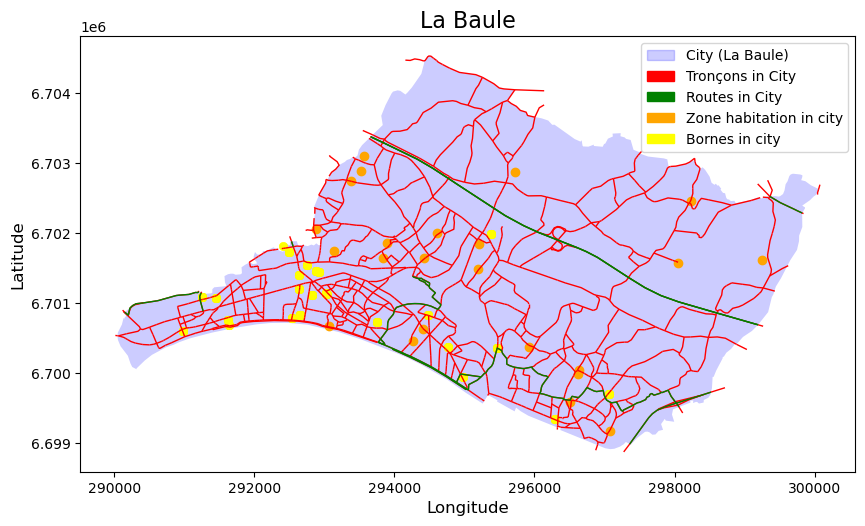

In [72]:
# Plot the POIs
fig, ax = plt.subplots(figsize=(10, 10))
gdf_la_baule.plot(ax=ax, color = 'blue', linewidth=1, alpha = 0.2)
gdf_troncons_in_city.plot(ax=ax, color = 'red', linewidth=1, alpha = 1)
gdf_routes_nommees_in_city.plot(ax=ax, color = 'green', linewidth=1, alpha = 1)
gdf_zone_habitation_in_city.plot(ax=ax, color = 'orange', linewidth=1, alpha = 1)
gdf_bornes_in_city.plot(ax=ax, color = 'yellow', linewidth=0.5, alpha = 1)
# gdf_pois_in_city.plot(ax=ax, color = 'pink', linewidth=1, alpha = 1)

# Create a manual legend
legend_city = mpatches.Patch(color="blue", alpha=0.2, label="City (La Baule)")
legend_troncons_in_city = mpatches.Patch(color="red", label="Tronçons in City")
legend_routes_in_city = mpatches.Patch(color="green", label="Routes in City")
legend_zone_habitation_in_city = mpatches.Patch(color="orange", label="Zone habitation in city")
# legend_pois_in_city = mpatches.Patch(color="pink", label="POI in city")
legend_bornes_in_city = mpatches.Patch(color="yellow", label="Bornes in city")
# ax.legend(handles=[legend_city, legend_troncons_in_city, legend_routes_in_city, legend_zone_habitation_in_city, legend_pois_in_city, legend_bornes_in_city], loc="upper right")
ax.legend(handles=[legend_city, legend_troncons_in_city, legend_routes_in_city, legend_zone_habitation_in_city, legend_bornes_in_city], loc="upper right")

# Customize the plot
ax.set_title("La Baule", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Show the plot
plt.show()

### Full plot Folium

In [36]:
### Converting all geopds to GPS coordinate
gdf_la_baule_gps = gdf_la_baule_gps.to_crs("EPSG:4326")
ign_geometry_la_baule_gps = gdf_la_baule_gps.iloc[0].geometry
gdf_zone_habitation_in_city_gps = gdf_zone_habitation_in_city.to_crs("EPSG:4326")
gdf_routes_nommees_in_city_gps = gdf_routes_nommees_in_city.to_crs("EPSG:4326")
gdf_troncons_in_city_gps = gdf_troncons_in_city.to_crs("EPSG:4326")


gdf_pois_in_city_points = gdf_pois_in_city.copy()
gdf_pois_in_city_points['geometry'] = gdf_pois_in_city_points.geometry.centroid
gdf_pois_in_city_points_gps = gdf_pois_in_city_points.to_crs("EPSG:4326")
gdf_pois_in_city_gps = gdf_pois_in_city.to_crs("EPSG:4326")

In [71]:

# Centrer la carte sur La Baule (approx.)
center_lat, center_lon = ign_geometry_la_baule_gps.centroid.y, ign_geometry_la_baule_gps.centroid.x
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Ajouter le contour de la ville
folium.GeoJson(
    ign_geometry_la_baule_gps,
    name="La Baule",
    style_function=lambda x: {"color": "black", "weight": 2, "fillOpacity": 0.1}
).add_to(m)

# Ajouter les routes nommées
folium.GeoJson(
    gdf_routes_nommees_in_city_gps,
    name="Routes nommées",
    style_function=lambda x: {"color": "red", "weight": 3}
).add_to(m)

# Ajouter les tronçons de route
folium.GeoJson(
    gdf_troncons_in_city_gps,
    name="Tronçons de routes",
    style_function=lambda x: {"color": "blue", "weight": 1, "alpha": 0.2}
).add_to(m)

# Ajouter les POIs avec des marqueurs
# marker_cluster = MarkerCluster(name="Points d'intérêt").add_to(m)
# for _, row in gdf_pois_in_city_points_gps.iterrows():
#     folium.Marker(
#         location=[row.geometry.y, row.geometry.x],
#         popup=f"POI ({row.nature}) : {row.toponyme}",
#         icon=folium.Icon(color="yellow", icon="info-sign")
#     ).add_to(marker_cluster)


for idx, row in gdf_zone_habitation_in_city_gps.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        # icon=folium.Icon(color="blue", icon="info-sign"),
        icon=folium.Icon(color="blue", icon="home"),
        popup=f"ZA ({row.nature}): {row.toponyme}",  # Optional: Display info when clicked
    ).add_to(m)

# Add markers with detailed popups for each point in the GeoDataFrame
for idx, row in gdf_bornes_in_city_gps.iterrows():
    popup_text = f"""
    <strong>Charging Station</strong><br>
    Nb pdc: {row['nbre_pdc']}<br>
    Amenageur: {row['nom_amenageur']}<br>
    Operateur: {row['nom_operateur']}
    """
    marker_color = 'green' if row['nom_operateur'] in vinci_names_operateur else 'orange'
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=popup_text,
        icon=folium.Icon(color=marker_color, icon='star')
    ).add_to(m)

# Ajouter un contrôle des couches
folium.LayerControl().add_to(m)

# Afficher la carte
m

# Routing

## Routing between two points

In [41]:
# selecting two charging stations randomly in the city
random_stations_gps = gdf_bornes_in_city_gps.sample(frac=1).iloc[:2]
random_stations_gps[['consolidated_longitude', 'consolidated_latitude']]

consolidated_longitude  consolidated_latitude
22880               -2.378618              47.282340
23479               -2.393664              47.285892

In [42]:
start_point = [random_stations_gps.iloc[0].consolidated_longitude, random_stations_gps.iloc[0].consolidated_latitude]
end_point = [random_stations_gps.iloc[1].consolidated_longitude, random_stations_gps.iloc[1].consolidated_latitude]

In [45]:
import requests
from urllib.parse import urlencode

# Base URL
base_url = "https://data.geopf.fr/navigation/itineraire"

# Parameters as a dictionary
params = {
    "resource": "bdtopo-osrm",
    "start": f"{start_point[0]},{start_point[1]}",  # New start coordinates
    "end": f"{end_point[0]},{end_point[1]}",  # New end coordinates
    "profile": "car",
    "optimization": "fastest",
    "constraints": '{"constraintType":"banned","key":"wayType","operator":"=","value":"autoroute"}',
    "getSteps": "true",
    "getBbox": "true",
    "distanceUnit": "kilometer",
    # "timeUnit": "hour",
    "timeUnit": "minute",
    "crs": "EPSG:4326",
}

# Encode parameters properly and create full URL
query_string = urlencode(params)
full_url = f"{base_url}?{query_string}"

print("Generated URL:", full_url)

# Make the request
response = requests.get(full_url, headers={"Accept": "application/json"})

# Check response
if response.status_code == 200:
    data = response.json()
    print("Response:", data)
else:
    print(f"Error: {response.status_code}, {response.text}")

Generated URL: https://data.geopf.fr/navigation/itineraire?resource=bdtopo-osrm&start=-2.378618%2C47.28234&end=-2.39366363%2C47.28589164&profile=car&optimization=fastest&constraints=%7B%22constraintType%22%3A%22banned%22%2C%22key%22%3A%22wayType%22%2C%22operator%22%3A%22%3D%22%2C%22value%22%3A%22autoroute%22%7D&getSteps=true&getBbox=true&distanceUnit=kilometer&timeUnit=minute&crs=EPSG%3A4326
Response: {'resource': 'bdtopo-osrm', 'resourceVersion': '2025-01-22', 'start': '-2.378631,47.28237', 'end': '-2.393663,47.285848', 'profile': 'car', 'optimization': 'fastest', 'geometry': {'coordinates': [[-2.378625, 47.282371], [-2.378542, 47.282371], [-2.378435, 47.282339], [-2.378963, 47.282151], [-2.379086, 47.282101], [-2.379178, 47.282074], [-2.379276, 47.282053], [-2.379349, 47.282046], [-2.379515, 47.282056], [-2.379651, 47.282076], [-2.380027, 47.28213], [-2.380188, 47.282161], [-2.380337, 47.281828], [-2.381688, 47.282267], [-2.38357, 47.282888], [-2.384198, 47.28311], [-2.384397, 47.283

In [47]:
data.keys()

dict_keys(['resource', 'resourceVersion', 'start', 'end', 'profile', 'optimization', 'geometry', 'crs', 'distanceUnit', 'timeUnit', 'bbox', 'distance', 'duration', 'constraints', 'portions'])

In [48]:
# Extract important information
distance = data.get("distance")
distance_unit = data.get("distanceUnit")
duration = data.get("duration")
time_unit = data.get("timeUnit")

# Print the formatted information
print(f"Distance: {distance} {distance_unit}")
print(f"Duration: {duration} {time_unit}")

Distance: 1.4848 kilometer
Duration: 6.716666666666667 minute


In [49]:
# Convert coordinates to a LineString (longitude, latitude format)
line_geom = LineString(data['geometry']["coordinates"])

# Create a GeoDataFrame
gdf_routing_gps = gpd.GeoDataFrame([{"geometry": line_geom}], crs="EPSG:4326")  # WGS 84 CRS

# Display the GeoDataFrame
gdf_routing_gps

geometry
0  LINESTRING (-2.37862 47.28237, -2.37854 47.282...

In [50]:
# Centrer la carte sur La Baule (approx.)
center_lat, center_lon = ign_geometry_la_baule_gps.centroid.y, ign_geometry_la_baule_gps.centroid.x
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Ajouter le contour de la ville
folium.GeoJson(
    ign_geometry_la_baule_gps,
    name="La Baule",
    style_function=lambda x: {"color": "black", "weight": 2, "fillOpacity": 0.1}
).add_to(m)

# Ajouter les routes nommées
# folium.GeoJson(
#     gdf_routes_nommees_in_city_gps,
#     name="Routes nommées",
#     style_function=lambda x: {"color": "red", "weight": 3}
# ).add_to(m)

# Ajouter les tronçons de route
# folium.GeoJson(
#     gdf_troncons_in_city_gps,
#     name="Tronçons de routes",
#     style_function=lambda x: {"color": "blue", "weight": 1, "alpha": 0.2}
# ).add_to(m)

# Ajouter le chemin entre les points 
folium.GeoJson(
    gdf_routing_gps,
    name="Path between points",
    style_function=lambda x: {"color": "green", "weight": 4, "alpha": 0.2}
).add_to(m)


# Add markers with detailed popups for each point in the GeoDataFrame
for idx, row in random_stations_gps.iterrows():
    popup_text = f"""
    <strong>Charging Station</strong><br>
    Nb pdc: {row['nbre_pdc']}<br>
    Amenageur: {row['nom_amenageur']}<br>
    Operateur: {row['nom_operateur']}
    """
    marker_color = 'green' if row['nom_operateur'] in vinci_names_operateur else 'orange'
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=popup_text,
        icon=folium.Icon(color=marker_color, icon='star')
    ).add_to(m)

# Ajouter un contrôle des couches
folium.LayerControl().add_to(m)

# Afficher la carte
m

## Reachable area from one point

In [51]:
gdf_start_station = random_stations_gps.iloc[0]
start_point = [gdf_start_station.consolidated_longitude, gdf_start_station.consolidated_latitude]

In [54]:

def get_isochrone(
    point, resource="bdtopo-valhalla", cost_value=300, cost_type="time",
    profile="car", direction="departure", constraints=None,
    distance_unit="meter", time_unit="second", crs="EPSG:4326"
):
    """
    Sends a request to the GeoPF Isochrone API.

    Parameters:
        point (tuple): (longitude, latitude) of the starting location.
        resource (str): Routing engine to use (default: "bdtopo-valhalla").
        cost_value (int): Value for the cost function (e.g., time in seconds).
        cost_type (str): Cost type ("time" or "distance").
        profile (str): Transport mode ("car", "bike", "foot", etc.).
        direction (str): "departure" (outward) or "arrival" (inward).
        constraints (dict or None): Constraints on the route.
        distance_unit (str): Distance unit ("meter", "kilometer", etc.).
        time_unit (str): Time unit ("second", "minute", etc.).
        crs (str): Coordinate reference system (default is EPSG:4326).

    Returns:
        dict: The JSON response from the API.
    """

    base_url = "https://data.geopf.fr/navigation/isochrone"

    # Format constraints as a JSON string if provided
    constraints_str = json.dumps(constraints) if constraints else None

    # Define query parameters
    params = {
        "point": f"{point[0]},{point[1]}",  # Format as "longitude,latitude"
        "resource": resource,
        "costValue": cost_value,
        "costType": cost_type,
        "profile": profile,
        "direction": direction,
        "constraints": constraints_str,  # JSON-encoded constraints
        "distanceUnit": distance_unit,
        "timeUnit": time_unit,
        "crs": crs
    }

    # Send request
    response = requests.get(base_url, params=params, headers={"accept": "application/json"})

    # Check response status
    if response.status_code == 200:
        return response.json()  # Return parsed JSON response
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None  # Return None if the request fails


In [55]:
# Example: Get an isochrone for a 5-minute drive (300 seconds)
# point_coords = (2.337306, 48.849319)  # Longitude, Latitude
point_coords = start_point

# Example constraints (ban highways)
constraints_example = {
    "constraintType": "banned",
    "key": "wayType",
    "operator": "=",
    "value": "autoroute"
}

cost_value = 300
cost_type = 'time'

# Call the function
isochrone_data = get_isochrone(point_coords, cost_value=cost_value, cost_type=cost_type, constraints=constraints_example)

In [57]:
# Convert coordinates to a Shapely Polygon
polygon = Polygon(isochrone_data['geometry']["coordinates"][0])  # Extract first polygon ring

# Create a GeoDataFrame
gdf_routing_area = gpd.GeoDataFrame({'geometry': [polygon]}, crs="EPSG:4326")  # WGS84

In [58]:
# Centrer la carte sur La Baule (approx.)
center_lat, center_lon = ign_geometry_la_baule_gps.centroid.y, ign_geometry_la_baule_gps.centroid.x
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Ajouter le contour de la ville
folium.GeoJson(
    ign_geometry_la_baule_gps,
    name="La Baule",
    style_function=lambda x: {"color": "black", "weight": 2, "fillOpacity": 0.1}
).add_to(m)


# Ajouter la zone reachable à partir d'un point  
folium.GeoJson(
    gdf_routing_area,
    name="Reachable area",
    style_function=lambda x: {"color": "green", "weight": 4, "alpha": 0.2},
    tooltip=f"Reachable area within {cost_value} {cost_type}"
).add_to(m)


# Add markers with detailed popups for each point in the GeoDataFrame
popup_text = f"""
<strong>Charging Station</strong><br>
Nb pdc: {row['nbre_pdc']}<br>
Amenageur: {row['nom_amenageur']}<br>
Operateur: {row['nom_operateur']}
"""
marker_color = 'green' if gdf_start_station['nom_operateur'] in vinci_names_operateur else 'orange'
folium.Marker(
    location=[gdf_start_station.geometry.y, gdf_start_station.geometry.x],
    popup=popup_text,
    icon=folium.Icon(color=marker_color, icon='star')
).add_to(m)

# Ajouter un contrôle des couches
folium.LayerControl().add_to(m)

# Afficher la carte
m

# OpenStreetMap : Advanced Points of interest

In [59]:
def format_bounding_box(bbox):
    # Swapping the order of coordinates and formatting them
    # bbox = (minx, miny, maxx, maxy)
    # We want: latitude (miny, maxy) and longitude (minx, maxx)
    
    min_lon, min_lat, max_lon, max_lat = bbox
    
    # Format the coordinates with 4 decimal places
    formatted = f"{min_lat:.4f},{min_lon:.4f},{max_lat:.4f},{max_lon:.4f}"
    
    return formatted

In [60]:
# Obtenir la bounding box de la baule sous format bbox = "48.8566,2.3522,48.8666,2.3622"  # Coordinates for Paris
bounding_box_city = ign_geometry_la_baule_gps.bounds
print(f"Bounding Box: {bounding_box_city}")
formatted_bbox_city = format_bounding_box(bounding_box_city)
print(f"Bounding Box: {formatted_bbox_city}")

Bounding Box: (-2.4272956419199745, 47.268046123850915, -2.297022884553247, 47.31688550368751)
Bounding Box: 47.2680,-2.4273,47.3169,-2.2970


### Restaurants

In [62]:
import requests

# Overpass API request to retrieve restaurants within the bounding box
url = f"http://overpass-api.de/api/interpreter?data=[out:json];(node[amenity=restaurant]({formatted_bbox_city}););out;"

# Send the request
response = requests.get(url)

# Check if the response is successful (status code 200)
if response.status_code == 200:
    data = response.json()

else:
    print(f"Error: {response.status_code}")


In [63]:
# Il n'y a que des noeuds
print(data['elements'][0])
for element in data['elements']:
    if element['type'] != 'node': 
        print(element)

{'type': 'node', 'id': 871856227, 'lat': 47.2715889, 'lon': -2.3453103, 'tags': {'amenity': 'restaurant', 'name': 'Le Saucier'}}


In [70]:
# Create a list of dictionaries with necessary fields for GeoDataFrame
gdf_restaurants = []

for item in data['elements']:
    # Create a Point geometry using latitude and longitude
    point = Point(item['lon'], item['lat'])
    
    # Extract other relevant fields (e.g., name, amenity)
    properties = {
        'id': item['id'],
        'name': item['tags'].get('name', 'Unknown'),
        'amenity': item['tags'].get('amenity', 'Unknown')
    }
    
    # Combine geometry (Point) with other properties
    gdf_restaurants.append({'geometry': point, **properties})

# Convert to GeoDataFrame
gdf_restaurants = gpd.GeoDataFrame(gdf_restaurants)

# Make sure the CRS (Coordinate Reference System) is set (WGS84 for lat/lon)
gdf_restaurants.set_crs("EPSG:4326", allow_override=True, inplace=True)

# Display the GeoDataFrame
gdf_restaurants['toponyme'] = gdf_restaurants['name']
gdf_restaurants = gdf_restaurants.drop(columns=['name'])

gdf_restaurants = gdf_restaurants[gdf_restaurants.geometry.intersects(ign_geometry_la_baule_gps)]

# gdf_restaurants

In [69]:
# Centrer la carte sur La Baule (approx.)
center_lat, center_lon = ign_geometry_la_baule_gps.centroid.y, ign_geometry_la_baule_gps.centroid.x
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Ajouter le contour de la ville
folium.GeoJson(
    ign_geometry_la_baule_gps,
    name="La Baule",
    style_function=lambda x: {"color": "black", "weight": 2, "fillOpacity": 0.1}
).add_to(m)

# Ajouter les routes nommées
folium.GeoJson(
    gdf_routes_nommees_in_city_gps,
    name="Routes nommées",
    style_function=lambda x: {"color": "red", "weight": 3}
).add_to(m)

# Ajouter les tronçons de route
folium.GeoJson(
    gdf_troncons_in_city_gps,
    name="Tronçons de routes",
    style_function=lambda x: {"color": "blue", "weight": 1, "alpha": 0.2}
).add_to(m)


# Add markers with detailed popups for each point in the GeoDataFrame
for idx, row in gdf_restaurants.iterrows():
    popup_text = f"""
    {row.amenity} : {row.toponyme} 
    """
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=popup_text,
        icon=folium.Icon(color=marker_color, icon='star')
    ).add_to(m)

# Ajouter un contrôle des couches
folium.LayerControl().add_to(m)

# Afficher la carte
m

## Other points of interests we can get

* Amenities :
    * Restaurants, Cafes, Bars, ...
    * Hospital, Pharmacies...
    * Universities...

* Landuse : 
    * Residential
    * Commercial 
    * Industrial

* Other : 
    * Mall, supermarkets...

In [96]:
# Overpass API request to retrieve restaurants within the bounding box
# Commented URL = ça marche pas

# url = f"http://overpass-api.de/api/interpreter?data=[out:json];(node[amenity=mall]({formatted_bbox_city}););out;"
# url = f"http://overpass-api.de/api/interpreter?data=[out:json];(node[amenity=supermarket]({formatted_bbox_city}););out;"
# url = f"http://overpass-api.de/api/interpreter?data=[out:json];(node[amenity=hospital]({formatted_bbox_city}););out;"
# url = f"http://overpass-api.de/api/interpreter?data=[out:json];(node[amenity=university]({formatted_bbox_city}););out;"
# url = f"http://overpass-api.de/api/interpreter?data=[out:json];(node({formatted_bbox_city}););out;"

url = f"http://overpass-api.de/api/interpreter?data=[out:json];(node[amenity=restaurant]({formatted_bbox_city}););out;"
url = f"http://overpass-api.de/api/interpreter?data=[out:json];(node[amenity=bank]({formatted_bbox_city}););out;"
url = f"http://overpass-api.de/api/interpreter?data=[out:json];(node[amenity=pharmacy]({formatted_bbox_city}););out;"
url = f"http://overpass-api.de/api/interpreter?data=[out:json];(node[amenity=school]({formatted_bbox_city}););out;"
url = f"http://overpass-api.de/api/interpreter?data=[out:json];(node[shop=supermarket]({formatted_bbox_city}););out;"
url = f"http://overpass-api.de/api/interpreter?data=[out:json];(node[shop=clothes]({formatted_bbox_city}););out;"
url = f"http://overpass-api.de/api/interpreter?data=[out:json];(node[shop]({formatted_bbox_city}););out;"
url = f"http://overpass-api.de/api/interpreter?data=[out:json];(node[amenity]({formatted_bbox_city}););out;"


# Send the request
response = requests.get(url)

# Check if the response is successful (status code 200)
if response.status_code == 200:
    data = response.json()

else:
    print(f"Error: {response.status_code}")

# Display the malls and their coordinates
for element in data['elements']:
    name = element.get('tags', {}).get('name', 'Unknown')
    lat = element['lat']
    lon = element['lon']
    print(f"Name: {name}, Coord: {lat}, {lon}")

Name: Toilettes Allée du Garde, Coord: 47.2789983, -2.4198387
Name: Unknown, Coord: 47.2816054, -2.3921759
Name: Unknown, Coord: 47.2717757, -2.3444577
Name: Le Saucier, Coord: 47.2715889, -2.3453103
Name: La Baule Guézy, Coord: 47.2718294, -2.3451812
Name: Unknown, Coord: 47.2717515, -2.3451799
Name: Crédit Mutuel, Coord: 47.2703419, -2.3443723
Name: Unknown, Coord: 47.2704347, -2.3449415
Name: Police Municipale, Coord: 47.2705675, -2.3451447
Name: Le Bidule, Coord: 47.269523, -2.3445283
Name: BNP Paribas, Coord: 47.2689348, -2.3428752
Name: Hôtel de Ville de Brécéan, Coord: 47.2699608, -2.4247224
Name: Unknown, Coord: 47.2746047, -2.4253531
Name: Avia, Coord: 47.2792256, -2.4223773
Name: La Baule, Coord: 47.2859032, -2.3896795
Name: Le M, Coord: 47.2825024, -2.3918962
Name: Le Khédive, Coord: 47.2825139, -2.3925723
Name: La Villa, Coord: 47.2824151, -2.3920624
Name: Marché de La Baule, Coord: 47.2850394, -2.3951311
Name: Le 10, Coord: 47.2833982, -2.4055488
Name: La Bergerie, Coord: 

In [98]:
data['elements']

[{'type': 'node',
  'id': 268984245,
  'lat': 47.2789983,
  'lon': -2.4198387,
  'tags': {'amenity': 'toilets', 'name': 'Toilettes Allée du Garde'}},
 {'type': 'node',
  'id': 746815786,
  'lat': 47.2816054,
  'lon': -2.3921759,
  'tags': {'amenity': 'toilets',
   'fee': 'no',
   'source': 'cadastre-dgi-fr source : Direction Générale des Impôts - Cadastre. Mise à jour : 2010',
   'wheelchair': 'no'}},
 {'type': 'node',
  'id': 871850844,
  'lat': 47.2717757,
  'lon': -2.3444577,
  'tags': {'amenity': 'recycling',
   'check_date:recycling': '2022-12-27',
   'location': 'underground',
   'recycling:cans': 'yes',
   'recycling:glass_bottles': 'yes',
   'recycling:paper': 'yes',
   'recycling_type': 'container'}},
 {'type': 'node',
  'id': 871856227,
  'lat': 47.2715889,
  'lon': -2.3453103,
  'tags': {'amenity': 'restaurant', 'name': 'Le Saucier'}},
 {'type': 'node',
  'id': 871860444,
  'lat': 47.2718294,
  'lon': -2.3451812,
  'tags': {'addr:housenumber': '121',
   'addr:postcode': '445